In [279]:
import numpy as np
import matplotlib.pyplot as plt
from dnn_app_utils_v3 import load_data
import copy

In [280]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [281]:
print(train_x_orig.shape)

(209, 64, 64, 3)


In [282]:
print(train_y.shape)

(1, 209)


In [283]:
print(train_x_orig.max())
print(train_x_orig.min())

255
0


0


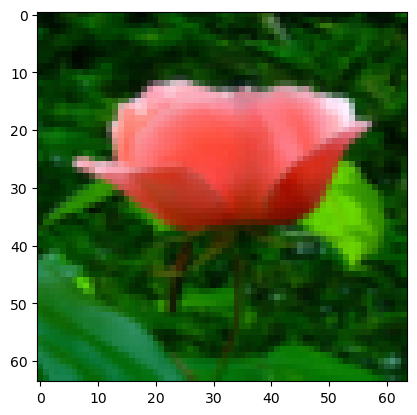

In [284]:
plt.imshow(train_x_orig[3])
print(train_y[0,3])

1


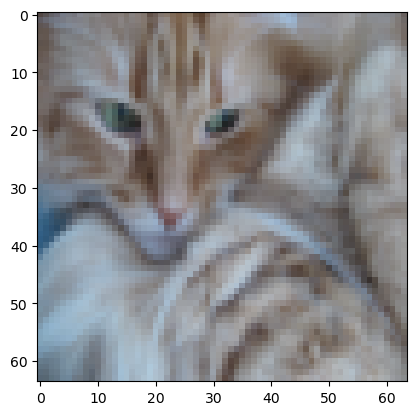

In [285]:
plt.imshow(train_x_orig[2])
print(train_y[0,2])
#아하 고양이 사진이면 1 아니면 0이구나!

In [286]:
print(test_x_orig.shape)

(50, 64, 64, 3)


### 데이터를 통해 알아낼 수 있는 것
 - train x는 64 * 64 * 3채널로 된 사진이 209개 있음
 - train y는 고양이인지 아닌지가 0과 1로 구분되어 있음
 - 고양이면 1, 아니면 0으로 라벨링이 되어있음
 - test 데이터는 50개

### 작명규칙
 - 데이터 변수는 train_x_orig 와 같고
 - y는 더이상 가공할 여지가 없으니 train_y로 함
 - train_x_orig -> train_x_flatten -> train_x 로 바뀔 예정

In [287]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

In [288]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print("train_x's shape:",train_x.shape)
print("test_x's shape:",test_x.shape , end=" ")
print("GOOD!!")

train_x's shape: (12288, 209)
test_x's shape: (12288, 50) GOOD!!


#### 고양이인지 아닌지 구별하는 2개의 아키텍쳐를 설계할것임
1. 2개의 레이어를 가진 NEURAL NETWORK
2. N개의 레이어를 가진 DEEP NEURAL NETWORK

-> 귀찮으니까 N개의 레이어를 가지도록 해서.. 걍 일반화할래잉

In [289]:
#실험해볼 점. 0.01을 하지 않고, 0.1 혹은 1로 하면 학습이 얼마나 지연될까?
def initialize_parameters_deep(layer_dims):
    '''
    layer_dims = [n_x, n_h1, n_h2, ...,n_y]
    '''
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        params['b' + str(l)] = np.zeros((layer_dims[l],1))

    return params

In [290]:
def relu(Z):
    '''
    a = (1,3,5)
    b = (6,4,2)
    np.maximum-> (6,4,5)
    '''
    return np.maximum(Z, 0)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [291]:
def forward(A_prev, W, b, activation = "relu"):

    Z = W @ A_prev + b
    activation_cache = Z

    linear_cache = (A_prev , W, b)

    if activation == "relu":
        A = relu(Z)

    elif activation == "sigmoid":
        A = sigmoid(Z)
    cache = (linear_cache, activation_cache)
    return A, cache
    


In [292]:
def L_model_forward(X, params):
    caches = []

    A = X
    L = len(params) //2 

    for l in range(1, L):
        A_prev = A
        A, cache = forward(A_prev,
                           params[f'W{str(l)}'],
                           params[f'b{str(l)}'],
                           activation = "relu",)
        caches.append(cache)
    # L-1번째까지 forward가 작동완료된 상황

    Y_hat, cache = forward(A,
                           params["W"+str(L)],
                           params["b"+str(L)],
                           activation = "sigmoid")
    caches.append(cache)
    return Y_hat, caches

In [293]:
def compute_cost(Y_hat,Y):
    m = Y.shape[1]
    cost = np.sum(Y* np.log(Y_hat) + (1-Y) * np.log(1-Y_hat)) / -m
    cost = np.squeeze(cost)
    return cost

In [294]:
def backward(dZ, linear_cache):
    A_prev, W,b = linear_cache

    m = A_prev.shape[1]
    dW = (dZ @ A_prev.T)/m
    db = np.sum(dZ, axis= 1, keepdims= True)/m
    dA_prev = W.T@dZ
    return dA_prev, dW, db

In [295]:
def relu_backward(dA, activation_cache):
    '''
    cache = Z
    '''
    
    
    Z = activation_cache
    dZ = np.array(dA, copy = True)
    
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, activation_cache):
    '''
    cache = Z
    '''
    Z = activation_cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [296]:
def backward_with_activation(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = backward(dZ, linear_cache)

    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = backward(dZ, linear_cache)
    return dA_prev, dW, db

In [297]:
def L_model_backward(Y_hat, Y, caches):
    '''
    caches = [cache-0, cache-1, ... ,cache-2,... ,cache-L-1] -> L개
    '''
    grads = {}
    L = len(caches)
    m = Y_hat.shape[1]
    Y = Y.reshape(Y_hat.shape)

    # dAL = - ( Y/Y_hat   -   (1-Y) / (1-Y_hat) ) -> y와 y_hat 을 통해 계산가능
    dAL = - (np.divide(Y,Y_hat) - np.divide((1-Y),(1-Y_hat)))

    #최초의 backward
    current_cache = caches[-1]
    dA_prev_temp, dW_temp, db_temp = backward_with_activation(dAL, current_cache, activation = "sigmoid")

    grads["dA"+str(L-1)] = dA_prev_temp 
    grads["dW"+str(L)] = dW_temp
    grads["db"+str(L)] = db_temp
    
    #L-1번째 LAYER부터 L번째 레이어까지
    for l in reversed(range(L-1)):
        #l = L-2 L-3 ,..., 2, 1, 0
        #l번째에는 relu가 쓰임
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_with_activation(dA_prev_temp , current_cache, activation = "relu")
        grads["dA"+str(l)] = dA_prev_temp #dA는 dA0 ~ dAL-1 + dAL
        grads["dW"+str(l+1)] = dW_temp #dW1 ~ dWL
        grads["db"+str(l+1)] = db_temp #db1 ~ dbL
    
    return grads


In [298]:
def update_params(params, grads, lr = 0.03):
    '''
    W = W - lr * dW    
    b = b - lr * db
    w,b는 params에, dw와 db는 grads에 있음
    params = {W1 : ... , b1 : ... , ~ , WL : ... , BL : ...} 
    grads  = {dA0: ... , dW1: ... , db1: ... , ~ , dAL: ..., dWL : ..., dWb : ...}
    '''
    parameters = copy.deepcopy(params)
    L = len(params) // 2 #float가 아닌 int를 반환하기 위해 //사용

    for l in range(1,L+1):
        # 위 params과 grads를 통해 업데이트를 하기 위해 다음과 같이 활용
        parameters['W' + str(l)] = parameters['W' + str(l)] - lr * grads['dW'+str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - lr * grads['db'+str(l)]
    return parameters

In [299]:
def make_layer_dims(X, Y, layer_size = 5, layer_unit_size = 50):
    layer_dims = [layer_unit_size] * (layer_size)
    layer_dims.insert(0,X.shape[0])
    layer_dims.append(Y.shape[0])
    return layer_dims

In [312]:
def l_layer_model(X, Y, layer_size, layer_unit_size= 50,lr = 0.03, iterations = 10000):
    layer_dims = make_layer_dims(X, Y, layer_size, layer_unit_size)
    params = initialize_parameters_deep(layer_dims)
    costs = []
    for i in range(iterations):
        Y_hat, caches = L_model_forward(X, params)
        if (i+1) % 100 == 0 :
            cost = compute_cost(Y_hat,Y)
            print("iteration: ",i+1)
            print("cost: ",cost)

            train_accuracy = 1 - np.mean(np.abs(Y_hat - Y))
            print("acc: ",train_accuracy * 100,"%")
            print("-"*50)
            if train_accuracy > 0.99:
                print("accuracy is over 99%. train breaked.")
                break

            costs.append(cost)
        grads = L_model_backward(Y_hat, Y, caches)
    
        params = update_params(params, grads, lr)
    return params

In [316]:
params = l_layer_model(train_x,train_y,4,7,0.0075,3000)

iteration:  100
cost:  0.6781336363520751
acc:  50.81943579784001 %
--------------------------------------------------
iteration:  200
cost:  0.667682817664249
acc:  51.50323177769447 %
--------------------------------------------------
iteration:  300
cost:  0.6604780972440699
acc:  52.066688323717024 %
--------------------------------------------------
iteration:  400
cost:  0.6554959307338073
acc:  52.53115090393388 %
--------------------------------------------------
iteration:  500
cost:  0.6520393326977694
acc:  52.9145595408238 %
--------------------------------------------------
iteration:  600
cost:  0.6496333979066989
acc:  53.23167725035759 %
--------------------------------------------------
iteration:  700
cost:  0.6479536914873949
acc:  53.49452771572314 %
--------------------------------------------------
iteration:  800
cost:  0.6467777725803042
acc:  53.712863235540695 %
--------------------------------------------------
iteration:  900
cost:  0.6459525222634427
acc:  

In [321]:
y_hat, _ = L_model_forward(test_x, params)
test_acc = 1 - np.mean(np.abs(y_hat - test_y))
print("test acc :", test_acc , "%")

test acc : 0.4505038619292434 %
